Let's now train and validate a simple ConvNet using the CIFAR-10 dataset.

In [0]:
%matplotlib inline
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Download the CIFAR-10 dataset. This is available in TorchVision.

In [2]:
num_workers = 2
test_batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./CIFAR', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./CIFAR', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 40000
n_val_samples = 10000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

Extracting ./CIFAR/cifar-10-python.tar.gz to ./CIFAR
Files already downloaded and verified


Let's see if we have downloaded correctly.

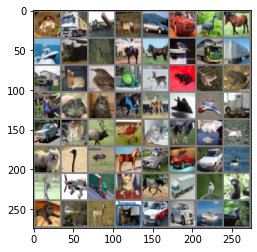

In [3]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
import matplotlib.pyplot as plt
imshow(torchvision.utils.make_grid(images))

OK, seems like it has been downloaded. Let us set up the ConvNet. Notice that as before, we first define the different layers, and then connect them together in the forward pass.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

Set up the loss (cross entropy), optimization algorithm (Adam), and the data loader.

In [0]:
def createLossAndOptimizer(net, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [0]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

In [0]:

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, label="Training loss", linewidth=2)
    plt.plot(x, val_history, label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

OK! Time to train the network. We will also keep track of the model with the best validation loss (this trick is called "early stopping").

In [0]:
import time

def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with torch.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))
    
    return train_history, val_history

In [13]:
net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size=32, n_epochs=15, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 15
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.95 took: 1.00s
Epoch 1, 20% 	 train_loss: 1.65 took: 0.99s
Epoch 1, 30% 	 train_loss: 1.52 took: 0.93s
Epoch 1, 40% 	 train_loss: 1.52 took: 0.92s
Epoch 1, 50% 	 train_loss: 1.44 took: 0.91s
Epoch 1, 60% 	 train_loss: 1.42 took: 0.97s
Epoch 1, 70% 	 train_loss: 1.38 took: 0.95s
Epoch 1, 80% 	 train_loss: 1.37 took: 0.88s
Epoch 1, 90% 	 train_loss: 1.32 took: 0.87s
Validation loss = 1.27
Epoch 2, 10% 	 train_loss: 1.20 took: 0.96s
Epoch 2, 20% 	 train_loss: 1.25 took: 0.94s
Epoch 2, 30% 	 train_loss: 1.21 took: 0.96s
Epoch 2, 40% 	 train_loss: 1.22 took: 0.89s
Epoch 2, 50% 	 train_loss: 1.21 took: 1.07s
Epoch 2, 60% 	 train_loss: 1.16 took: 0.92s
Epoch 2, 70% 	 train_loss: 1.18 took: 1.05s
Epoch 2, 80% 	 train_loss: 1.20 took: 1.03s
Epoch 2, 90% 	 train_loss: 1.14 took: 0.91s
Validation loss = 1.19
Epoch 3, 10% 	 train_loss: 1.08 took: 1.10s
Epoch 3, 20% 	 train_loss: 1.09 took: 0.9

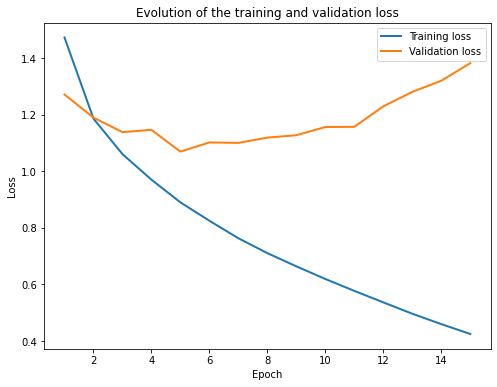

In [16]:
plot_losses(train_history, val_history)

Hmm, looks like some overfitting has happened. Good that we saved the best possible model. Let's now plot confusion matrices.

Ground truth:

Predicted:

       cat       ship       ship      plane       frog       frog        car       frog        cat        car      plane      truck        dog      horse      truck       ship        cat        cat       ship       frog      horse      plane      plane        car       deer       frog       bird       deer      truck       frog       frog       bird       bird        cat      truck      truck       deer      truck      truck        dog      plane       frog        cat       frog      plane      truck        dog      horse      horse       bird      truck      plane       bird        cat       ship       ship      horse        dog        dog        cat      horse        dog       frog      plane


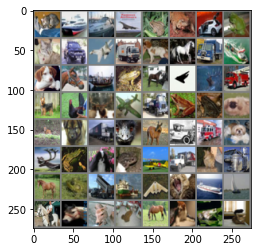

In [18]:
try:
  images, labels = next(iter(test_loader))
except EOFError:
  pass

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground truth:\n")

outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted:\n")
print(' '.join('{:>10}'.format(classes[predicted[j]]) for j in range(test_batch_size)))

Cool! Seems like it's working. Let's compute test accuracy and confusion matrices.

In [19]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 50000 train images: 70.37 %
Accuracy of the network on the 10000 validation images: 62.56 %
Accuracy of the network on the 10000 test images: 63.32 %


Not bad for a shallow ConvNet. We can also show which classes were the best.

In [20]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(predicted.size(0)):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        60.60   
car          73.50   
bird         45.90   
cat          45.70   
deer         58.30   
dog          58.90   
frog         75.80   
horse        64.30   
ship         79.70   
truck        70.50   


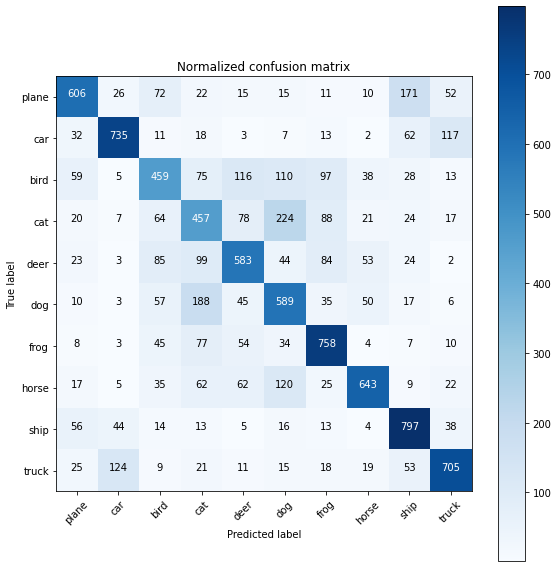

In [23]:
# Plot normalized confusion matrix
import itertools

plot_confusion_matrix(confusion_matrix, classes, 
                      title='Normalized confusion matrix')